### Preliminaries

In [70]:
import os.path # Directories, gotta have em.
import pickle # Better than .csv + a cute name.
from time import localtime, strftime # Time stamp everything.
import pandas as pd # DataFrames. Looping is easy. Obscure functions are fast.
import numpy as np # Do math on vectors with more obscure functions.
from IPython.display import display # Show me what's going on.
import collections
import re

import spacy # The engine. Big thanks to the geniuses at Explosion.
from spacy.tokens import Doc, DocBin
from spacy.matcher import DependencyMatcher
nlp = spacy.load('en_core_web_trf', exclude=["ner"])

print('Working Directory set to:', os.getcwd())

Working Directory set to: /home/jovyan/work/jupyter-1


In [104]:
class corpus:    
    # set a name extension on Doc if not present
    # used for storing file names from which text was extracted
    if Doc.has_extension('name'):
        pass
    else:
        Doc.set_extension('name', default=None)

    def __init__(self, file_name, reference = False):
        # set reference boolean attribute
        self.ref = reference
        
        # initialize matcher
        self.matcher = DependencyMatcher(nlp.vocab)

        def doc_listerizer(self, doc_bin):
            docs = list(doc_bin.get_docs(nlp.vocab))
            return docs

        def file_retriever(self, file_name):
            if os.path.isfile(file_name):
                print('Retrieving processed corpus from file',
                      strftime("%Y-%m-%d %H:%M:%S", localtime()))
                doc_bin = DocBin().from_disk(file_name)
                print('Making corpus into a list',
                      strftime("%Y-%m-%d %H:%M:%S", localtime()))
                docs = doc_listerizer(self, doc_bin)
                return docs
            else:
                print('No Corpus Found. Ensure the directory is correct or run Corpus Preprocessing.')
                
        self.docs = file_retriever(self, file_name)
    
    def add_matcher(self, patterns_frame):
        def pattern_extractor(coltype, headtag, deptag, deprels):
            if 'any' in deprels:
                dep_pat = {"POS": deptag, "IS_ALPHA": True}
            else:
                dep_pat = {"POS": deptag, "DEP": {"IN": deprels}, "IS_ALPHA": True}
            pattern = [
                {
                    "RIGHT_ID": (coltype + ' head'),
                    "RIGHT_ATTRS": {"POS": headtag, "IS_ALPHA": True}
                },
                {
                    "LEFT_ID": (coltype + ' head'),
                    "REL_OP": ">",
                    "RIGHT_ID": (coltype + ' dependent'),
                    "RIGHT_ATTRS": dep_pat
                }]
            self.matcher.add(coltype, [pattern])
            print('...' + str(len(self.matcher)), coltype)
        
        # Read from pre-processed dataframe mapping 
        # ACL collocation types to spaCy POS/DEP tags.
        for coltype in patterns_frame.itertuples(index=True):
            deprels = list(coltype[4].split("/"))
            pattern_extractor(coltype[1],coltype[2], coltype[3], deprels)        

            
    def extract_candidates(self):
        def extractor(self):
            matches = [] # Lists of name, matchlist tuples.
            list_dep_bigrams = [] # Initialize list of tuples with output information
        
            for idoc, doc in enumerate(self.docs):
                tuplematch = (idoc, doc._.name, self.matcher(doc))
                matches.append(tuplematch)
            return matches
        
        def organizer(self, matches):
            list_dep_bigrams = []
            for idoc, name, matchlist in matches:
                for match_id, (ihead, idep) in matchlist:
                    string_id = nlp.vocab.strings[match_id]
                    # start, end = sorted([ihead, idep])
                    head = self.docs[idoc][ihead]
                    dep = self.docs[idoc][idep]
                    # underscores after attribute denote string form
                    # removing the underscores would result in a hashed 64-bit number
                    # using the hashes would make this faster
                    list_dep_bigrams.append((idoc,
                                             name,
                                             string_id, 
                                             head.lemma_, 
                                             head.tag_, 
                                             dep.dep_, 
                                             dep.lemma_, 
                                             dep.tag_))
            
            candidates = pd.DataFrame(
                list_dep_bigrams,
                columns=["index",
                         "id",
                         "type",
                         "hlem",
                         "htag",
                         "deprel",
                         "dlem",
                         "dtag"])

            return candidates
        
        def counter(df):
            num_candidates = df.shape[0]
            print('The number of bigrams extracted is', f"{num_candidates:,}")
            
            # Combine by collocation and document identifier 
            # (which was retrieved from the original txt filename)
            # and create a column with the counts
            output = df.value_counts(["id",
                                  "type",
                                  "hlem", 
                                  "htag",
                                  "dlem", 
                                  "dtag"]
                               ).reset_index(name='toks')
            
            return output
        
        def statifier(df):
            num_candidates = df.shape[0]
            print('The number of bigrams extracted is', f"{num_candidates:,}")
            
            # Combine collocations and create a column with the counts
            df = df.value_counts(["type",
                                 "hlem", 
                                 "htag",
                                 "dlem", 
                                 "dtag"]
                               ).reset_index(name='freq')
            
            # we named this column 'toks'
            # but let's also convert it to a series
            # using Evert's notation to make things more clear
            o_11 = df['freq']
    
            # word 1 (head) without word 2 (dep)
            o_12 = df.groupby(['type',
                               'hlem', 
                               'htag']
                             )['freq'].transform('sum') - df['freq'] 
            
            # word 2 (dep) without word 1 (head)
            o_21 = df.groupby(['type',
                               'dlem', 
                               'dtag']
                             )['freq'].transform('sum') - df['freq']
            
            # all dependency bigrams with neither word 1 nor word 2
            o_22 = num_candidates - o_11 - o_12 - o_21

            # Intermediate Values
            c_1 = o_11 + o_21
            c_2 = o_12 + o_22
            r_1 = o_11 + o_12
            r_2 = o_21 + o_22
            
            # Expected co-occurrence if no relationship
            e_11 = r_1 * c_1 / num_candidates
            
            dfstats = df.assign(mi = np.log2(o_11 / e_11),
                                mi2 = np.log2(o_11**2 / e_11),
                                t = (o_11 - e_11) / np.sqrt(o_11),
                                twf = lambda x: (.56*x['mi']) + (.31*o_11*.65),
                                dpf = (o_11/r_1) - (o_21/r_2), # Delta-P Forward; head->dependent
                                dpb = (o_11/c_1) - (o_12/c_2), # Delta-P Backward; depoendent->head
                                ld = (14 + np.log2((2*o_11) / (r_1+c_1))))
            
            df = dfstats[dfstats['freq'] >= 5]
            
            return df
        
        print('Extracting Candidates',
              strftime("%Y-%m-%d %H:%M:%S", localtime()))
        matches = extractor(self)
        print("Organizing the matches.",
              strftime("%Y-%m-%d %H:%M:%S", localtime()))
        candidates = organizer(self, matches)
        if self.ref:
            print('Calculating Statistics',
                  strftime("%Y-%m-%d %H:%M:%S", localtime()))
            self.stats = statifier(candidates)
        else:
            self.extracts = counter(candidates)
  

    def search(self, word1 = None, word2 = None, matchname = 'Match', word1dict = None, word2dict = None):
        matcher = DependencyMatcher(nlp.vocab)
        
        if not word1dict:
            word1dict = {'LEMMA': word1} 
        if not word2dict:
            word2dict = {'LEMMA': word2}
        pattern = [
            {
                "RIGHT_ID": ('word1'),
                "RIGHT_ATTRS": word1dict
            },
            {
                "LEFT_ID": ('word1'),
                "REL_OP": ">",
                "RIGHT_ID": ('word2'),
                "RIGHT_ATTRS": word2dict
            }
        ]
        matcher.add(matchname, [pattern])
        
        matches = [] # Lists of name, matchlist tuples.

        for idoc, doc in enumerate(self.docs):
            protomatch = matcher(doc)
            if protomatch:
                tuplematch = (
                    doc._.name, 
                    idoc, matcher(doc)
                )
                matches.append(tuplematch)
        if matches:
            for name, idoc, matchlist in matches:
                for match_id, (ihead, idep) in matchlist:
                    string_id = nlp.vocab.strings[match_id]
                    # start, end = sorted([ihead, idep])
                    head = self.docs[idoc][ihead]
                    dep = self.docs[idoc][idep]
                    if self.ref == True:
                        display(head.sent)
                    elif self.ref == False:
                        display(name, head.sent)
        else:
            print('No Matches Found')

In [105]:
# File that you have already run through the Spacy pipeline
# This should be a Spacy Doc_Bin
refcorpusname = os.path.join('processedcorpora', 'OANCProcessed.spacy')

# table with three columns 
# Can have any names but must be in the order
# ["type", "headword tags", "dependent word tags"]
# where type can be any identifier such as "Noun + Noun"
# But tags must be Broad POS tags in Spacy Glossary
# e.g. "Noun", "Adj"
relations = pd.read_csv("coltypes.csv")

# retrieves list of docs from Doc_Bin
OANC = corpus(refcorpusname, reference = True)

# Creates Matcher object from table
OANC.add_matcher(relations)

# if reference = False (default value)
# extracted bigrams are saved at .extracts
# if reference = True
# Association Measures are calculated
# and dataframe is saved at .stats
OANC.extract_candidates()


# You can also recover this from a file
# To save processing time
refcorpusstatsname = os.path.join('Vocab', 'OANCBigramStats.pickle')
# OANC.stats = pd.read_pickle(refcorpusstatsname)


Retrieving processed corpus from file 2021-05-03 06:03:21
Making corpus into a list 2021-05-03 06:03:23
...1 NOUN + ADJ
...2 NOUN + NOUN
...3 VERB + OBJ
...4 VERB + SUBJ
...5 VERB + ADJ
...6 VERB + ADV
...7 ADJ + ADV
...8 NOUN + DET
...9 NOUN + PREP
...10 PREP + NOUN
...11 VERB + PART
...12 VERB + PREP
...13 VERB + VERB
...14 VERB + AUX
Extracting Candidates 2021-05-03 06:03:39
Organizing the matches. 2021-05-03 06:06:46
Calculating Statistics 2021-05-03 06:07:04
The number of bigrams extracted is 8,284,478


In [106]:
# Where you would like to save the bigram stats
ref_bigrams_pickle_name = os.path.join('Vocab', 'OANCBigramStats.pickle')

# show the results
display(OANC.stats)
# display(corpusname.extracts)

# save the file
# OANC.stats.to_pickle(ref_bigrams_pickle_name)

,type,hlem,htag,dlem,dtag,freq,mi,mi2,t,twf,dpf,dpb,ld
0,VERB + PART,be,VB,to,TO,13382,5.199490,18.907496,112.532426,2699.384715,0.867581,0.066470,10.989065
1,NOUN + DET,lot,NN,a,DT,10230,4.828652,18.149171,97.584129,2064.049045,0.936206,0.036167,10.159529
2,NOUN + PREP,lot,NN,of,IN,7361,4.516073,17.361759,82.046583,1485.770501,0.898376,0.021601,9.438364
3,VERB + AUX,know,VB,do,VBP,7059,7.452848,20.238096,83.538298,1426.562095,0.692619,0.214192,12.391690
4,VERB + PART,do,VB,to,TO,6837,5.304673,18.043821,80.594127,1380.626117,0.934141,0.034027,10.073971
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213462,NOUN + NOUN,boutique,NNS,designer,NN,5,12.389709,14.711637,2.235651,7.945737,0.060230,0.053754,9.862496
213463,VERB + PREP,balance,VBN,with,IN,5,4.159310,6.481238,2.110925,3.336714,0.121031,0.000080,1.461787
213464,VERB + SUBJ,provide,VBZ,rule,NN,5,6.705884,9.027812,2.214648,4.762795,0.006253,0.009885,6.985422
213465,VERB + VERB,be,VBD,happen,VB,5,3.310332,5.632260,2.010657,2.861286,0.000709,0.006833,4.547965


In [96]:
OANC.search('banana', 'green')
OANC.search(matchname = 'Match', word1dict = {'LEMMA': 'banana'}, word2dict = {'LEMMA': 'green', 'POS': 'ADJ'})
OANC.search(matchname = 'Match', word1dict = {'LEMMA': 'banana'}, word2dict = {'LEMMA': 'green', 'TAG': 'JJ'})
OANC.search(matchname = 'Match', word1dict = {'LEMMA': 'banana'}, word2dict = {'LEMMA': 'green', 'DEP': 'amod'})

and then they deep fry it and they use green bananas you know so that the bananas kind of stay together

and then they deep fry it and they use green bananas you know so that the bananas kind of stay together

and then they deep fry it and they use green bananas you know so that the bananas kind of stay together

and then they deep fry it and they use green bananas you know so that the bananas kind of stay together

### We will run through the same process for the target corpus

In [109]:
targetcorpusname = os.path.join('processedcorpora', 'ICNALEProcessed.spacy')

relations = pd.read_csv("coltypes.csv")

ICNALE = corpus(targetcorpusname, reference = False)

ICNALE.add_matcher(relations)

ICNALE.extract_candidates()

targetcorpusstatsname = os.path.join('Vocab', 'ICNALEBigramStats.pickle')
# ICNALE.extracts = pd.read_pickle(targetcorpusstatsname)# Where you would like to save the bigram stats

display(ICNALE.extracts)

# save the file
# ICNALE.extracts.to_pickle(targetcorpusstatsname)

Retrieving processed corpus from file 2021-05-03 06:18:27
Making corpus into a list 2021-05-03 06:18:27
...1 NOUN + ADJ
...2 NOUN + NOUN
...3 VERB + OBJ
...4 VERB + SUBJ
...5 VERB + ADJ
...6 VERB + ADV
...7 ADJ + ADV
...8 NOUN + DET
...9 NOUN + PREP
...10 PREP + NOUN
...11 VERB + PART
...12 VERB + PREP
...13 VERB + VERB
...14 VERB + AUX
Extracting Candidates 2021-05-03 06:18:29
Organizing the matches. 2021-05-03 06:18:41
The number of bigrams extracted is 817,845


,id,type,hlem,htag,dlem,dtag,toks
0,W_THA_PTJ0_172_B1_2.txt,NOUN + NOUN,job,NN,time,NN,20
1,W_KOR_SMK0_179_B1_2.txt,NOUN + DET,restaurant,NN,the,DT,18
2,W_PAK_PTJ0_049_A2_0.txt,NOUN + NOUN,job,NN,time,NN,16
3,W_PAK_PTJ0_049_A2_0.txt,NOUN + NOUN,time,NN,part,NN,15
4,W_PAK_PTJ0_160_B1_2.txt,NOUN + NOUN,time,NN,part,NN,15
...,...,...,...,...,...,...,...
716049,W_JPN_PTJ0_098_A2_0.txt,ADJ + ADV,important,JJ,most,RBS,1
716050,W_JPN_PTJ0_098_A2_0.txt,NOUN + ADJ,man,NN,big,JJ,1
716051,W_JPN_PTJ0_098_A2_0.txt,NOUN + ADJ,thing,NNS,various,JJ,1
716052,W_JPN_PTJ0_098_A2_0.txt,NOUN + DET,college,NN,another,DT,1


In [275]:
essaystatsfile = os.path.join('Corpus info', 'WE24.csv')

'''
You may need to reformat your datasets to facilitate the merge
It will be simplest to create a dataframe with 
one row per document, an id column
that corresponds to the document filename,
and one column for each variable
'''

# display(ICNALE.extracts)
def reformatter(input_df):
    local_df = input_df.copy()
    local_df[['W', 'country', 'essay', 'id', 'CEFR']] = local_df['id'].str.split('_',expand=True,n=4)
    local_df['id'] = local_df[['W', 'country', 'id']].apply(lambda x: '_'.join(x), axis='columns')
    local_df.drop(['W', 'country', 'CEFR'], axis=1, inplace=True)
    output = local_df.copy()
    return output

df = reformatter(ICNALE.extracts)

# studentinfo = pd.read_csv(essaystatsfile)
# studentinfo['ID'] = (studentinfo['ID'] + '.txt').astype(str)
# studentinfo.rename(columns = {'ID':'id'}, inplace = True)
# display(studentinfo)

# # For ICNALE written essays 2.4
studentinfo = pd.read_csv(essaystatsfile)
studentinfo = studentinfo[['Code', 'VST', 'CEFR']]

studentinfo.rename(columns = {'Code':'id'}, inplace = True)
# display(studentinfo)

merged_data = df.merge(studentinfo, on='id', how='left')
# display(merged_data)

common_cols = ["type", "hlem", "htag", "dlem", "dtag"]
data = merged_data.merge(OANC.stats, on=common_cols, how='inner')
# display(data)

# collocation_frame class

In [437]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from scipy.sparse import csr_matrix # This would be more efficient than a Pandas pivot table, not currently used
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

scaler = StandardScaler() # fit and transform the data

class collocation_frame:
    def __init__(self, dataframe):
        self.ams = ["mi", "mi2", "t", "dpf", "dpb", "ld", "twf"]
        self.coll_ids = ['type', 'hlem', 'htag', 'dlem', 'dtag']
        self.data = dataframe
    def sort_by_colls(self):
        self.by_colls = self.data.groupby(self.coll_ids).agg({
                                                'toks':'mean', 
                                                'mi':'mean', 
                                                'mi2':'mean',
                                                't':'mean', 
                                                'dpf': 'mean',
                                                'dpb': 'mean',
                                                'ld':'mean',
                                                'twf':'mean',
                                                'VST': 'mean'})
    def add_colls(self):
        self.colls = self.data[self.coll_ids].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    def bin_colls(self):
#         self.cats = ['95','98','99']
#         self.cats = ['vlow','low', 'midlow', 'mid', 'midhigh', 'high','vhigh']
        self.cats = ['low', 'mid', 'high']
        self.catcolls = self.data.copy()
        for am in self.ams:
            self.catcolls[am] = pd.cut(self.data[am],
                                       len(self.cats),
#                                        [0,.95,.98,1.],
                                       labels=self.cats)
            


In [438]:
merged_data.rename(columns = {'toks_x':'toks', 'toks_y':'freq'}, inplace = True)
display(merged_data['type'].value_counts())

PREP + NOUN    84417
NOUN + DET     83914
VERB + VERB    69672
VERB + OBJ     69388
VERB + AUX     62940
VERB + PREP    62241
NOUN + ADJ     53932
NOUN + NOUN    46455
VERB + ADV     44789
VERB + SUBJ    41139
NOUN + PREP    36513
VERB + PART    35000
VERB + ADJ     15478
ADJ + ADV      10176
Name: type, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

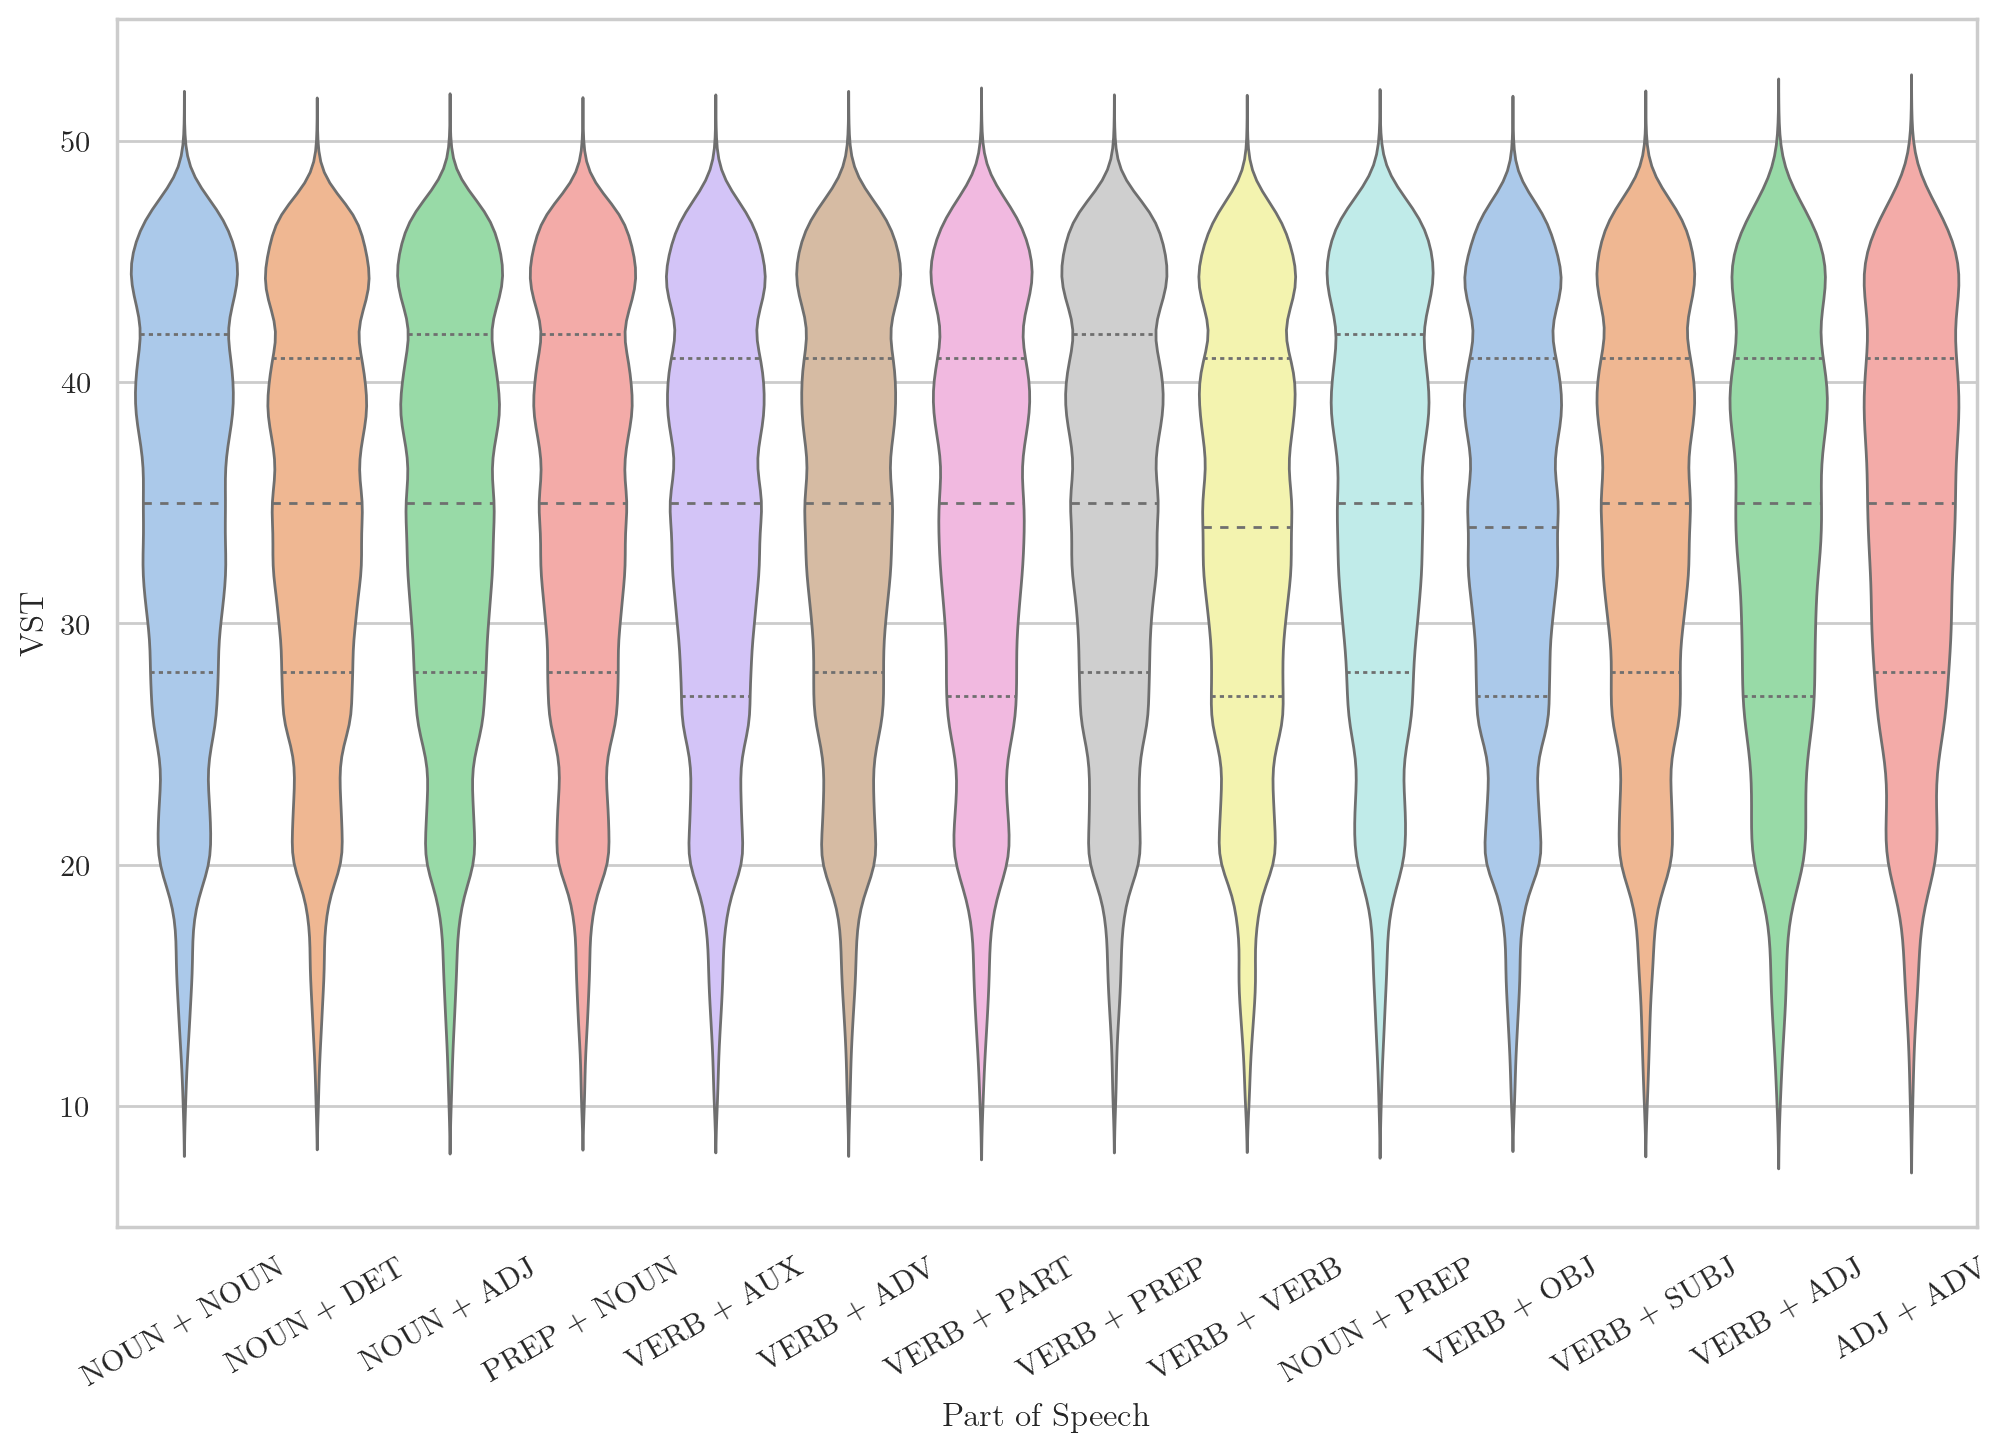

In [439]:
sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "text.usetex": True,
    'figure.figsize': [12, 8],
    'figure.dpi': 200,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# # Draw a nested violinplot and split the violins for easier comparison
ax = (sns.violinplot(data=merged_data, x = "type", y = "VST",
               split=False, inner="quart", linewidth=1, palette='pastel'))
ax.set(xlabel='Part of Speech')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show

What I want to do is recode the AMs by binning.

For each AM I want three bins. I will toss out the middle bin and just look at low/high.

Each AM will have a set of violins.

y=VST
x=coltype
hue=high/low (by AM)

In [440]:
ic = collocation_frame(data)
display(ic.data)
ic.sort_by_colls()

melted = ic.by_colls.copy().reset_index().melt(id_vars=["type","hlem","htag","dlem","dtag"], value_vars=["mi", 'mi2'])
new = melted[melted['type'] == 'VERB + OBJ']

# # Draw a nested violinplot and split the violins for easier comparison
# ax = sns.violinplot(data=new, x = "variable", y = "value",
#                split=False, inner="quart", linewidth=1, palette='pastel')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# plt.show

,id,type,hlem,htag,dlem,dtag,toks,essay,VST,CEFR,freq,mi,mi2,t,twf,dpf,dpb,ld
0,W_THA_172,NOUN + NOUN,job,NN,time,NN,20,PTJ0,36.0,B1_2,50,8.717439,14.361295,7.054269,14.956766,0.145432,0.017392,8.994600
1,W_PAK_049,NOUN + NOUN,job,NN,time,NN,16,PTJ0,20.0,A2_0,50,8.717439,14.361295,7.054269,14.956766,0.145432,0.017392,8.994600
2,W_THA_324,NOUN + NOUN,job,NN,time,NN,15,PTJ0,20.0,A2_0,50,8.717439,14.361295,7.054269,14.956766,0.145432,0.017392,8.994600
3,W_THA_099,NOUN + NOUN,job,NN,time,NN,13,PTJ0,25.0,B1_1,50,8.717439,14.361295,7.054269,14.956766,0.145432,0.017392,8.994600
4,W_KOR_268,NOUN + NOUN,job,NN,time,NN,13,PTJ0,40.0,B2_0,50,8.717439,14.361295,7.054269,14.956766,0.145432,0.017392,8.994600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445239,W_JPN_101,NOUN + DET,play,NN,a,DT,1,PTJ0,23.0,B1_1,80,3.265100,9.587028,8.013910,17.948456,0.293773,0.000263,3.212613
445240,W_JPN_101,VERB + PREP,develop,VB,at,IN,1,PTJ0,23.0,B1_1,12,3.720884,7.305846,3.201382,4.501695,0.048010,0.000341,3.580479
445241,W_JPN_101,VERB + PREP,succeed,VB,without,IN,1,PTJ0,23.0,B1_1,5,7.139275,9.461204,2.220206,5.005494,0.064475,0.001302,5.395261
445242,W_JPN_096,PREP + NOUN,with,IN,employee,NN,1,PTJ0,31.0,B1_1,5,2.823251,5.145179,1.920130,2.588521,0.000059,0.053670,1.161623


mid     260810
low     180784
high      3650
Name: mi, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

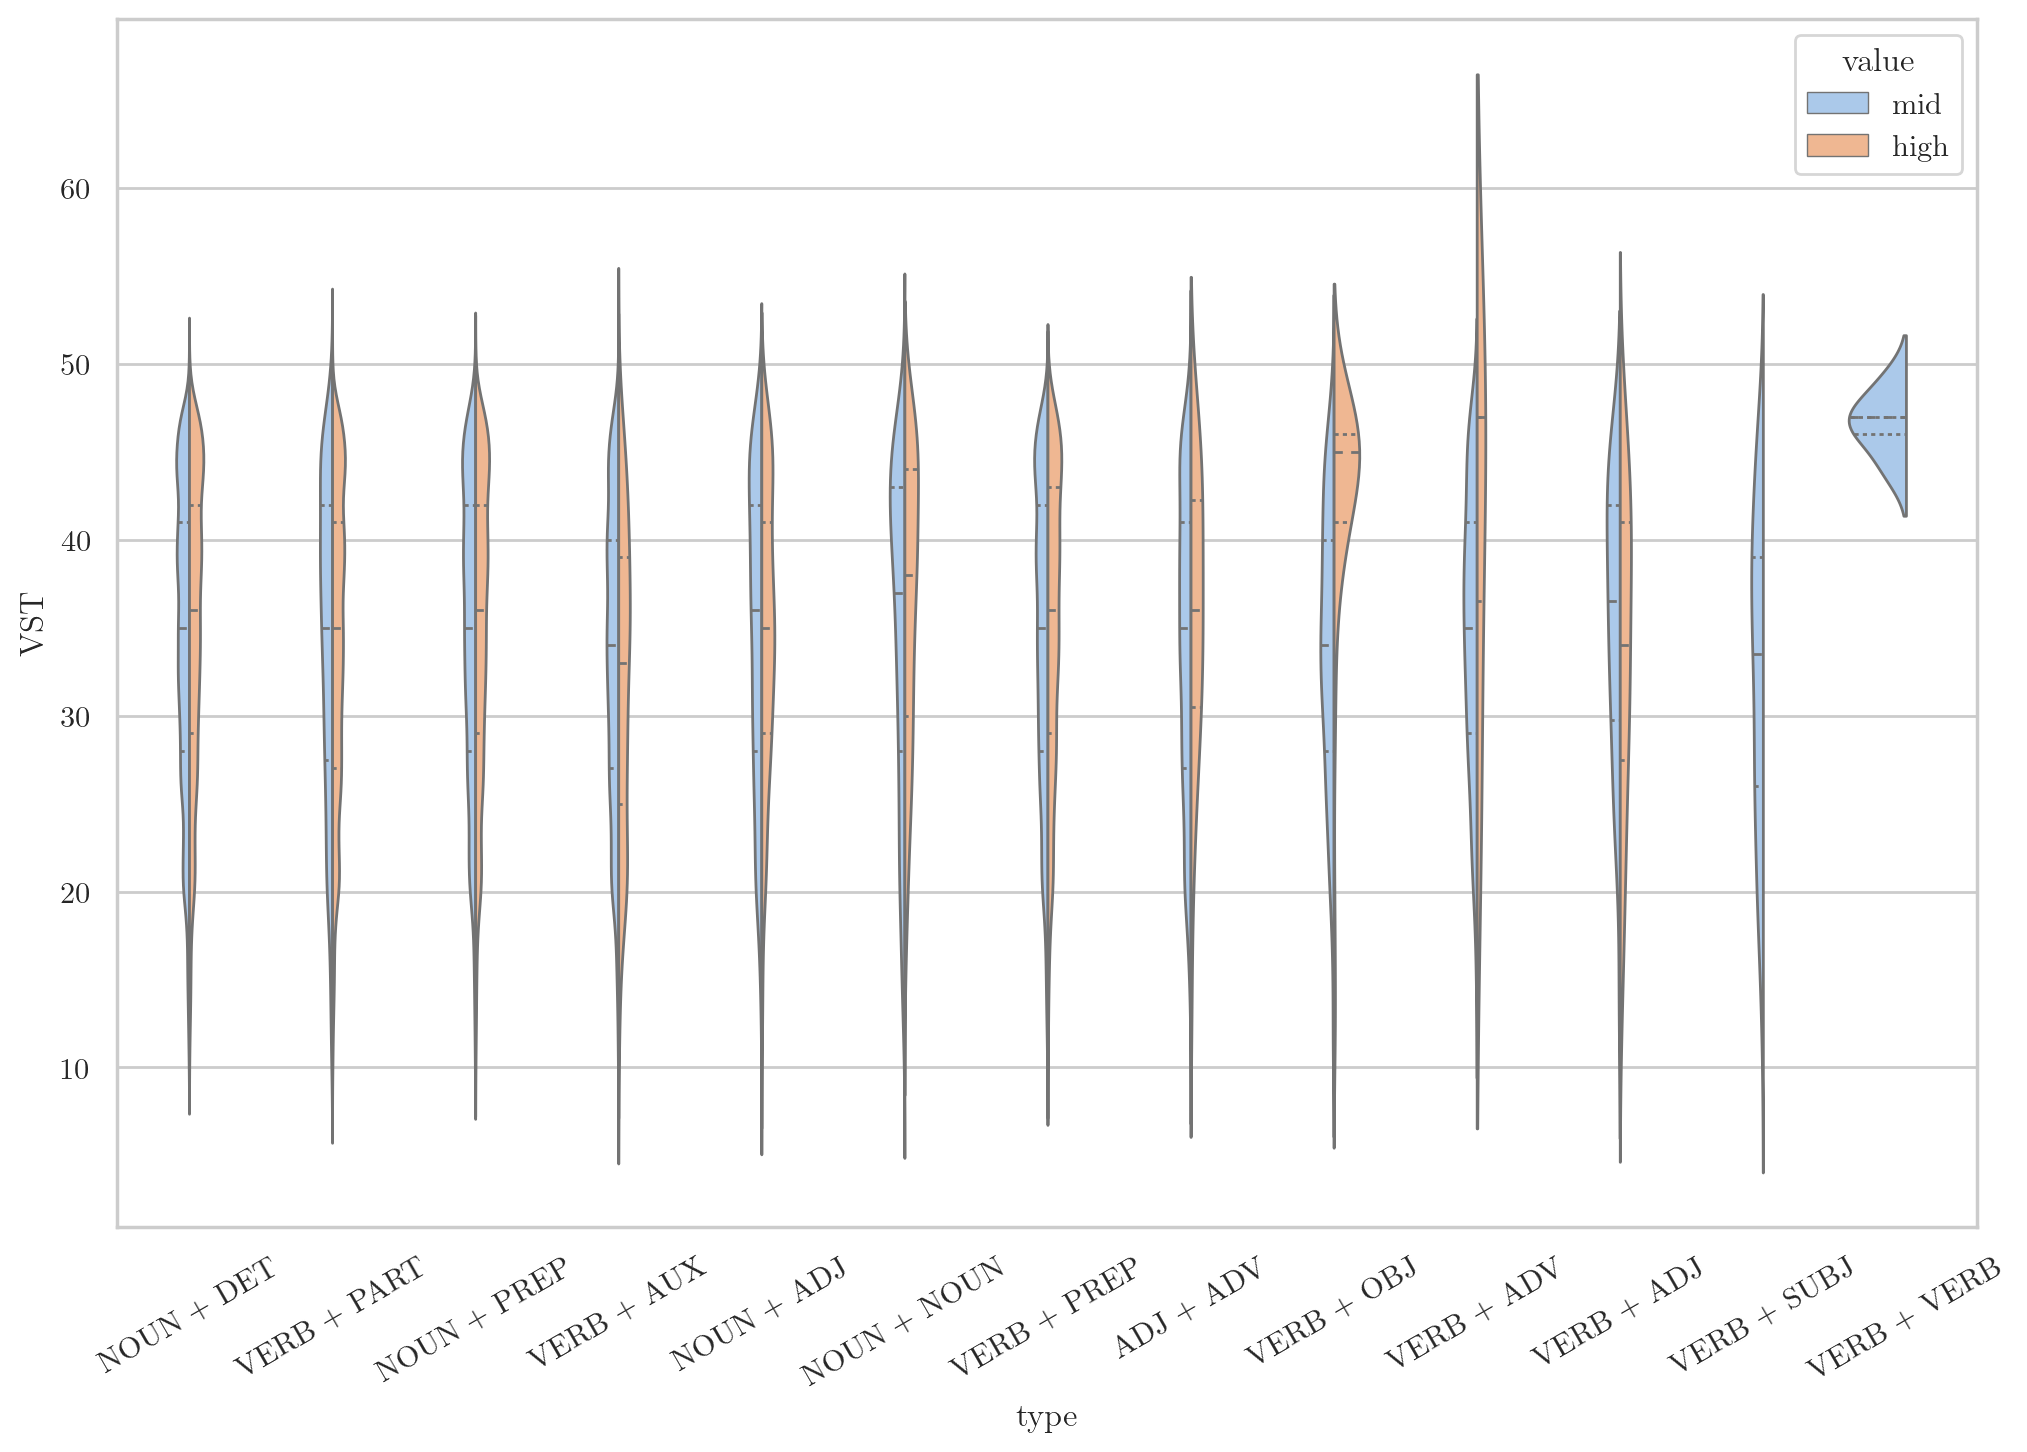

In [472]:
ic.bin_colls()
display(ic.catcolls['mi'].value_counts())

melted = ic.catcolls.reset_index(inplace=False).melt(id_vars=["type","hlem","htag","dlem","dtag","VST", "CEFR"], value_vars=ic.ams)
# cats = ['low','vhigh']
# new = melted[melted["value"].isin(cats)]
fig = plt.figure(1)
melted = melted[melted["value"].isin(['mid','high'])]

# [new["variable"].isin(['mi','mi2'])]
# # Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=melted[melted["variable"]=="dpf"], x = "type", y = "VST", hue = 'value', scale_hue=False,
#                     hue_order=ic.cats,
                    split=True, scale='area', inner="quart", linewidth=1, palette='pastel')
# ax.set(xlabel='Measure of Association Strength')
# ax.get_legend().set_title("Bin")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

# ax.set_xticklabels(['MI',r'MI\textsuperscript{2}','T',r'$\Delta$P-forward',r'$\Delta$P-back','Log-Dice','TWF'])
plt.show

B1_2    1073310
B1_1    1025773
A2_0     494095
B2_0     280196
XX_0     243334
Name: CEFR, dtype: int64

,type,hlem,htag,dlem,dtag,CEFR,variable,value
0,NOUN + NOUN,job,NN,time,NN,B1_2,mi,8.717439
1,NOUN + NOUN,job,NN,time,NN,A2_0,mi,8.717439
2,NOUN + NOUN,job,NN,time,NN,A2_0,mi,8.717439
3,NOUN + NOUN,job,NN,time,NN,B1_1,mi,8.717439
4,NOUN + NOUN,job,NN,time,NN,B2_0,mi,8.717439
...,...,...,...,...,...,...,...,...
3116703,NOUN + DET,play,NN,a,DT,B1_1,twf,17.948456
3116704,VERB + PREP,develop,VB,at,IN,B1_1,twf,4.501695
3116705,VERB + PREP,succeed,VB,without,IN,B1_1,twf,5.005494
3116706,PREP + NOUN,with,IN,employee,NN,B1_1,twf,2.588521


<function matplotlib.pyplot.show(close=None, block=None)>

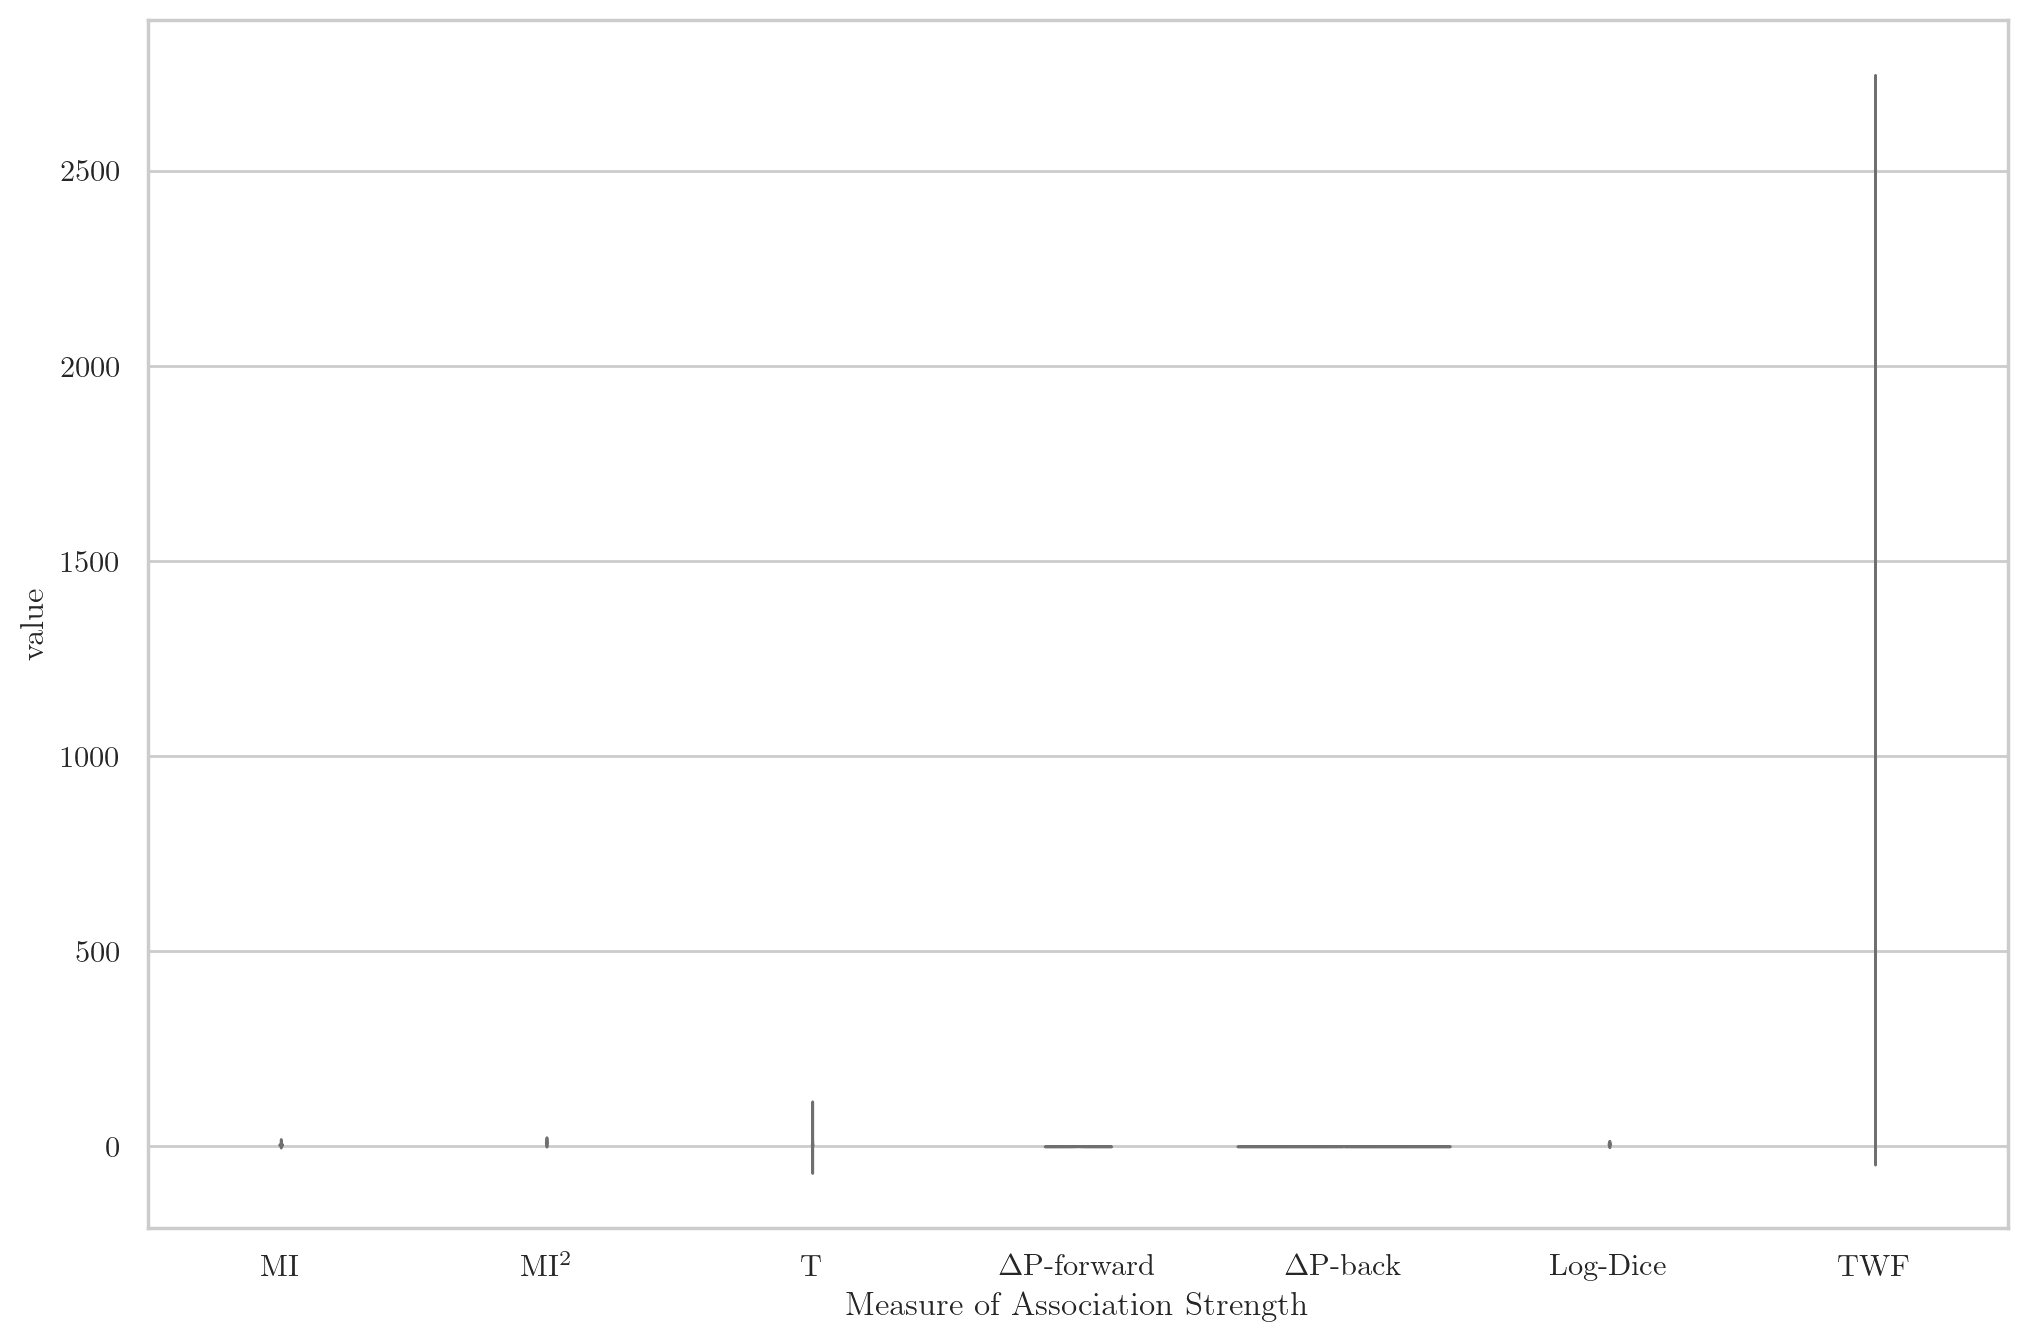

In [460]:
# cats = ['low','vhigh']
# new = melted[melted["value"].isin(cats)]
fig = plt.figure(1)
melted = ic.data.copy().reset_index().melt(id_vars=["type","hlem","htag","dlem","dtag","CEFR"], value_vars=ic.ams)
display(melted["CEFR"].value_counts())
display(melted)
# [new["variable"].isin(['mi','mi2'])]
# # Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=melted[melted["CEFR"] == "B1_2"], x = "variable", y = "value", split=False, scale='area', inner="quart", linewidth=1, palette='pastel')
# ['A2_0','B1_1','B1_2','B2_0']
ax.set(xlabel='Measure of Association Strength')
# ax.get_legend().set_title("CEFR")
ax.set_xticklabels(['MI',r'MI\textsuperscript{2}','T',r'$\Delta$P-forward',r'$\Delta$P-back','Log-Dice','TWF'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

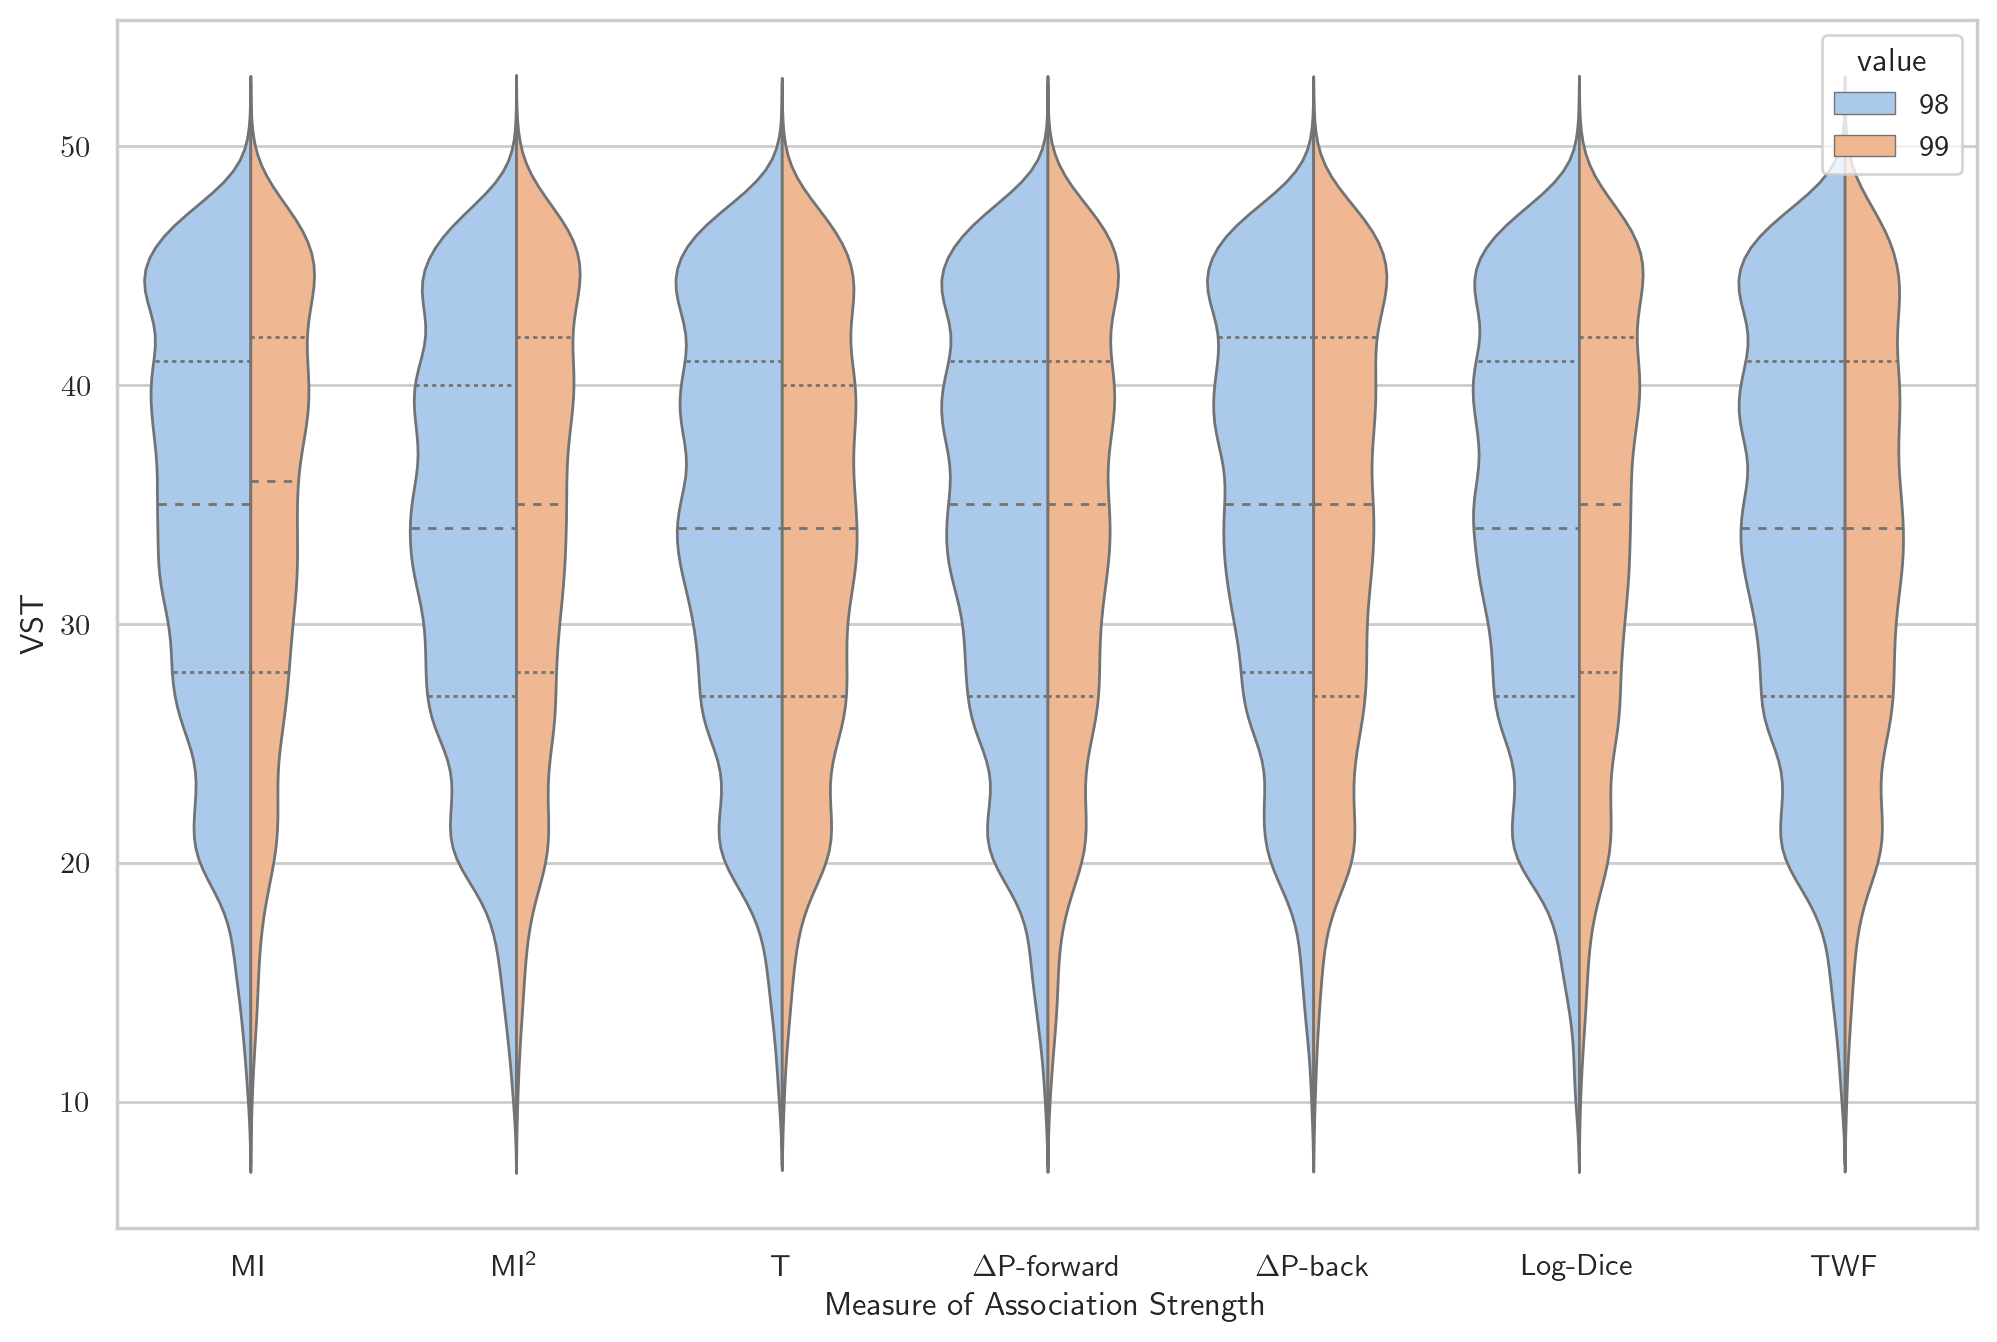

In [433]:
fig = plt.figure(1)
# # Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=melted[melted["value"] != '95'], x = "variable", y = "VST", hue = "value",
               split=True, scale='count', inner="quart", linewidth=1, palette='pastel')
ax.set(xlabel='Measure of Association Strength')
# fig._legend.set_title('Association Strength')
ax.set_xticklabels(['MI',r'MI\textsuperscript{2}','T',r'$\Delta$P-forward',r'$\Delta$P-back','Log-Dice','TWF'])
fig.savefig("seaborntest.png")
plt.show

In [ ]:
ic.add_colls()
display(ic.colls.nunique)

# Thoughts for Future work...

1. I think determining lexical proficiency using AMs is possible. I suspect a more specialized reference corpus could greatly improve the results. The most predictive combinations were either prompt-specific or genre-specific. Combinations such as "I know" and "I think" are indicators of lower lexical proficiency in academic argumentative writing. A reference corpus of student academic argumentative writing would be ideal to identify combinations such as this, but an op-ed corpus should work pretty well too.
2. I think it would be possible to determine erroneous combinations using delta-P and a VERY large reference corpus (COCA). This would be immensely coputationally expensive, and I don't know how well it would work. Computational costs could be reduced by limiting searches to combinations of specific types. 